# **PROBLEM STATEMENT AND DATA DESCRIPTION:**

**Hostile Post Detection in Hindi** :
       
This subtask focuses on a variety of **hostile posts in Hindi** Devanagari script **collected from Twitter and Facebook**. The set of valid categories are fake news, hate speech, offensive, defamation, and non-hostile posts. It is a **multi-label multi-class classification problem** where each post can belong to one or more of these hostile classes. However, the non-hostile posts cannot be grouped with any other class. The evaluation of this subtask will be two-dimensional as follows:

**Coarse-grained evaluation:** It is a binary evaluation of hostile vs non-hostile posts.

**Fine-grained evaluation:** It is a fine-grained evaluation of the hostile classes.

**Definitions of the class labels:**

**Fake News:** A claim or information that is verified to be not true.

**Hate Speech:** A post targeting a specific group of people based on their ethnicity, religious beliefs, geographical belonging, race, etc., with malicious intentions of spreading hate or encouraging violence.

**Offensive:** A post containing profanity, impolite, rude, or vulgar language to insult a targeted individual or group.

**Defamation:** A mis-information regarding an individual or group.

**Non-hostile:** A post without any hostility.

**Evaluation Metric:** 

The official evaluation metric for the shared task is  **weighted-average F1 score**.

# **IMPORTING LIBRARIES :**

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# importing the libraries
import numpy as np
import pandas as pd
import math as m 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier


# **MODELLING:**

## **Loading Trained Data returned by mBERT:**


Here the data used for Modelling is the result of cleaned data which is taken from CLF output of multilingual Bert 

In [ ]:
# loading the data returned from Bert
train= np.load('/content/gdrive/My Drive/Train_Representations_mBERT.npy',allow_pickle=True)
test= np.load('/content/gdrive/My Drive/Test_Representations_mBERT.npy',allow_pickle=True)
train_labels= np.load('/content/gdrive/My Drive/Train_Labels.npy',allow_pickle=True)
test_labels= np.load('/content/gdrive/My Drive/Test_Labels.npy',allow_pickle=True)

In [ ]:
# convert .npy files to dataframe 
x_train=pd.DataFrame(train)
x_test=pd.DataFrame(test)

In [ ]:
x_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,-0.732588,0.710685,-0.320207,0.830607,0.866882,0.621439,0.289335,-0.811108,-0.455411,-0.793067,-0.815261,-0.893141,0.445581,0.248246,0.089955,-0.693864,-0.589695,-0.619997,0.780396,-0.595645,0.489230,0.353845,-0.676800,-0.829196,-0.450532,-0.168453,-0.457432,-0.902954,-0.067576,0.732085,0.083550,0.639736,-0.757121,-0.876423,0.675147,-0.787643,0.643941,-0.647686,0.529392,-0.057115,...,-0.614511,0.367720,-0.789704,-0.611657,0.876787,-0.732111,0.358988,0.251144,0.214304,0.540675,0.822590,-0.340512,-0.592783,0.825689,-0.306878,0.080668,0.754077,0.546853,-0.784766,-0.717220,-0.476861,0.482289,0.436524,-0.778217,0.866543,0.585288,0.587465,0.987188,-0.673292,-0.672684,0.006438,-0.728774,-0.905429,-0.734196,-0.236235,0.833119,-0.275730,-0.519080,-0.810788,0.524842
1,0.740924,0.030430,-0.449941,0.469014,0.069717,-0.714667,-0.702413,0.031764,-0.694685,0.549749,0.210313,0.810892,-0.790786,-0.743319,-0.381748,-0.178590,0.563576,0.798982,-0.033410,-0.687859,-0.538312,0.626031,0.436732,0.802431,-0.685902,-0.833336,-0.593772,0.730593,0.117065,-0.471525,0.781842,-0.717936,0.165608,0.739031,-0.641787,0.357024,0.812486,-0.319017,0.737088,-0.600888,...,0.167454,0.682751,0.761724,-0.408915,0.329764,-0.688318,-0.222881,0.772413,-0.115886,-0.683200,-0.578816,0.383935,0.750939,-0.655920,-0.723357,0.812904,-0.266620,0.677562,-0.419448,-0.631253,-0.612940,-0.841314,-0.784482,0.846942,-0.781842,-0.749302,-0.143584,0.840547,-0.211017,-0.525201,-0.634581,0.714767,0.662392,-0.015599,-0.742255,-0.734037,0.544445,0.104345,0.148530,0.511468
2,0.781734,-0.003297,-0.471779,0.544349,0.016093,-0.711072,-0.573455,0.095652,-0.770301,0.547369,0.225308,0.751640,-0.771595,-0.774239,-0.541316,-0.166537,0.622713,0.792530,-0.061677,-0.660783,-0.574746,0.671598,0.424552,0.821605,-0.696766,-0.842904,-0.545900,0.766793,0.126307,-0.535921,0.780351,-0.705352,0.243269,0.710903,-0.720899,0.271711,0.835703,-0.303214,0.737156,-0.644042,...,0.266356,0.741960,0.756402,-0.336063,0.470029,-0.687680,-0.324832,0.808871,-0.140541,-0.724489,-0.582541,0.464643,0.749559,-0.621750,-0.727557,0.801081,-0.186788,0.701421,-0.298746,-0.647527,-0.663116,-0.688352,-0.802460,0.845327,-0.801355,-0.748439,-0.244254,0.847448,-0.252710,-0.553241,-0.634092,0.784254,0.610089,-0.050198,-0.763514,-0.744090,0.493762,0.133799,0.105474,0.467554
3,-0.744606,0.764933,-0.231929,0.817712,0.833094,0.697169,0.253331,-0.756506,-0.349598,-0.814932,-0.805438,-0.863923,0.531099,0.364355,0.264765,-0.718481,-0.645375,-0.669395,0.812572,-0.542420,0.519840,0.294183,-0.691517,-0.806066,-0.380125,0.099475,-0.388068,-0.907049,-0.049741,0.685456,-0.023177,0.615710,-0.811889,-0.847218,0.635233,-0.817634,0.582290,-0.652200,0.422401,-0.061026,...,-0.658973,0.240340,-0.848518,-0.493888,0.795197,-0.720787,0.348561,-0.032997,0.340780,0.535746,0.838689,-0.365553,-0.637877,0.831474,-0.208785,-0.041729,0.757448,0.448592,-0.752853,-0.630604,-0.483085,0.792773,0.544032,-0.732893,0.858338,0.608440,0.596441,0.969823,-0.650090,-0.692505,0.113471,-0.746093,-0.880959,-0.672832,-0.214177,0.877333,-0.356047,-0.510230,-0.762685,0.506918
4,0.774036,0.016017,-0.451547,0.551840,0.039809,-0.728371,-0.599640,0.084241,-0.744135,0.554946,0.202289,0.765284,-0.775677,-0.772673,-0.511907,-0.155191,0.643631,0.773615,-0.096573,-0.671992,-0.560466,0.689830,0.394631,0.794537,-0.721360,-0.827626,-0.516831,0.745294,0.149893,-0.535676,0.797109,-0.721649,0.191339,0.727591,-0.731698,0.238135,0.851838,-0.333948,0.727532,-0.640501,...,0.280129,0.719920,0.744078,-0.340250,0.457225,-0.698597,-0.300760,0.780165,-0.115395,-0.700699,-0.567758,0.461888,0.762728,-0.631608,-0.742902,0.791906,-0.211219,0.718073,-0.336529,-0.648245,-0.657412,-0.666318,-0.790687,0.862514,-0.780496,-0.749193,-0.194627,0.8

In [ ]:
x_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,0.727502,0.011243,-0.467984,0.571245,0.060416,-0.726072,-0.649169,0.146978,-0.746521,0.531886,0.211846,0.770344,-0.761274,-0.756878,-0.541705,-0.131372,0.573518,0.776543,-0.105236,-0.687468,-0.585769,0.681613,0.428735,0.815939,-0.701426,-0.837903,-0.573501,0.748696,0.100726,-0.563301,0.786285,-0.715220,0.172105,0.750478,-0.706496,0.309624,0.841288,-0.244592,0.747568,-0.646657,...,0.210935,0.729748,0.757902,-0.312272,0.388349,-0.678788,-0.299276,0.769832,-0.114645,-0.749215,-0.580068,0.470850,0.754006,-0.615156,-0.733181,0.802749,-0.168567,0.698226,-0.321995,-0.674512,-0.619030,-0.701229,-0.792387,0.852660,-0.797343,-0.743494,-0.162317,0.797574,-0.263969,-0.547296,-0.612569,0.751568,0.654832,0.047102,-0.781962,-0.757271,0.542628,0.139290,0.104002,0.504401
1,-0.676964,0.685156,-0.384752,0.869102,0.862156,0.618207,0.221776,-0.798615,-0.434710,-0.812352,-0.796630,-0.904728,0.407483,0.202314,0.161006,-0.718164,-0.450518,-0.619480,0.815309,-0.618710,0.466710,0.325960,-0.698508,-0.805896,-0.469325,-0.154987,-0.375674,-0.891725,0.052837,0.740693,0.165952,0.644648,-0.746170,-0.847375,0.671502,-0.817470,0.660787,-0.723469,0.486908,-0.023316,...,-0.609398,0.495201,-0.816249,-0.618296,0.921647,-0.803137,0.322692,0.151149,0.293551,0.611904,0.811154,-0.447241,-0.620624,0.793466,-0.311524,0.013621,0.687390,0.574774,-0.758605,-0.685408,-0.551354,0.655503,0.361233,-0.715680,0.891313,0.545944,0.629721,0.994584,-0.621504,-0.794502,0.022901,-0.710130,-0.898802,-0.731665,-0.354049,0.865085,-0.323622,-0.545879,-0.814437,0.535207
2,0.777822,0.004835,-0.448092,0.573206,0.021950,-0.705602,-0.582029,0.052576,-0.775060,0.569575,0.180514,0.742350,-0.756073,-0.762054,-0.528167,-0.151489,0.639000,0.795091,-0.031133,-0.622948,-0.601213,0.665174,0.435739,0.819363,-0.708881,-0.841029,-0.556917,0.773052,0.161851,-0.548974,0.795311,-0.708155,0.230134,0.723631,-0.718151,0.310568,0.824735,-0.252165,0.734213,-0.649410,...,0.296795,0.731696,0.760132,-0.364206,0.496273,-0.697339,-0.346969,0.790176,-0.101821,-0.707041,-0.600261,0.460348,0.758464,-0.632417,-0.755153,0.797012,-0.146669,0.680862,-0.324084,-0.634997,-0.627225,-0.699401,-0.801236,0.844131,-0.793721,-0.746827,-0.216187,0.847595,-0.237989,-0.538315,-0.620506,0.772085,0.625093,-0.077928,-0.770437,-0.727151,0.525415,0.191602,0.096546,0.467808
3,0.646729,0.311024,-0.582803,0.718245,0.371884,-0.663043,-0.613093,-0.268285,-0.752557,0.401028,-0.075087,0.699511,-0.777632,-0.682590,-0.511369,-0.528752,0.448617,0.628861,0.151190,-0.651223,-0.548580,0.739821,0.207785,0.749402,-0.774966,-0.822134,-0.632910,0.464108,0.010848,-0.267734,0.805370,-0.649244,-0.101725,0.619055,-0.614371,0.002020,0.886996,-0.613559,0.681640,-0.718174,...,-0.159081,0.799277,0.595288,-0.427722,0.267177,-0.818863,-0.107695,0.819174,0.187874,-0.737861,-0.344020,0.318540,0.663859,-0.554339,-0.768714,0.730115,-0.005627,0.738927,-0.367838,-0.660598,-0.748839,-0.533240,-0.822131,0.786770,-0.734505,-0.706263,0.005604,0.840597,-0.432220,-0.673963,-0.625916,0.683952,0.553784,-0.186486,-0.820705,-0.601467,0.480933,0.082433,-0.142637,0.603286
4,0.743800,0.060436,-0.539539,0.605774,0.094064,-0.725081,-0.540902,0.090068,-0.768050,0.531974,0.177663,0.747387,-0.762427,-0.769673,-0.554799,-0.252582,0.609113,0.750427,-0.051112,-0.640613,-0.562181,0.693705,0.401013,0.851980,-0.712351,-0.819551,-0.497157,0.691706,0.236964,-0.529363,0.799092,-0.694873,0.133512,0.732512,-0.708701,0.244365,0.843869,-0.359573,0.713257,-0.704495,...,0.164749,0.783881,0.750262,-0.407089,0.263336,-0.692100,-0.299789,0.802011,0.018707,-0.739840,-0.556438,0.410863,0.726612,-0.611489,-0.771832,0.769622,-0.070092,0.706637,-0.235830,-0.675641,-0.711078,-0.675566,-0.800038,0.844119,-0.799347,-0.752692,-0.109745,0.713799

In [ ]:
print("x_train shape ",x_train.shape)
print("x_test shape ",x_test.shape)

x_train shape  (5728, 768)
x_test shape  (811, 768)


In [ ]:
y_train=pd.DataFrame(train_labels)
y_test=pd.DataFrame(test_labels)

In [ ]:
x_train.corr().head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,1.000000,-0.993814,-0.872804,-0.977676,-0.995235,-0.997506,-0.994642,0.993961,-0.958390,0.998938,0.997769,0.998833,-0.996133,-0.988269,-0.983723,0.989714,0.997675,0.998130,-0.996679,-0.691830,-0.997037,0.977998,0.998192,0.999046,-0.970912,-0.979034,-0.808424,0.999217,0.530217,-0.998230,0.987804,-0.998687,0.997253,0.999015,-0.998987,0.997660,0.962158,0.973958,0.951700,-0.992519,...,0.995242,0.942912,0.999042,0.939332,-0.950051,0.532707,-0.986163,0.971134,-0.963083,-0.995155,-0.999120,0.995344,0.998959,-0.999279,-0.976301,0.986288,-0.996872,0.942048,0.991592,0.438315,-0.935837,-0.986969,-0.994885,0.999231,-0.999084,-0.998618,-0.995724,-0.915534,0.964259,0.942236,-0.985010,0.998586,0.998825,0.987768,-0.985537,-0.999005,0.996065,0.992500,0.995524,0.043075
1,-0.993814,1.000000,0.857110,0.974137,0.992913,0.991827,0.984496,-0.989295,0.953135,-0.993478,-0.994343,-0.992178,0.988989,0.981090,0.976204,-0.989813,-0.992981,-0.990798,0.992206,0.690540,0.992039,-0.963727,-0.993931,-0.992650,0.963281,0.970991,0.793018,-0.995194,-0.521272,0.992765,-0.977434,0.992343,-0.994691,-0.993192,0.992851,-0.991076,-0.948024,-0.979705,-0.942985,0.981967,...,-0.995178,-0.935873,-0.993714,-0.937531,0.924363,-0.562996,0.982048,-0.963193,0.965383,0.988522,0.993712,-0.989851,-0.992158,0.993222,0.966279,-0.977746,0.991892,-0.934728,-0.986926,-0.441396,0.932846,0.983485,0.988617,-0.992637,0.993078,0.991675,0.992929,0.887850,-0.967075,-0.938587,0.977145,-0.993442,-0.992301,-0.984232,0.973762,0.993066,-0.989859,-0.990122,-0.990480,-0.010351
2,-0.872804,0.857110,1.000000,0.817612,0.856579,0.885273,0.870050,-0.859857,0.911200,-0.868552,-0.867244,-0.870379,0.896775,0.902293,0.900134,-0.835110,-0.879012,-0.883731,0.876278,0.781998,0.884589,-0.907133,-0.866591,-0.874966,0.903048,0.911988,0.809676,-0.869448,-0.382772,0.869370,-0.898211,0.876121,-0.872596,-0.870580,0.874185,-0.868319,-0.923824,-0.813103,-0.897884,0.893496,...,-0.860244,-0.915175,-0.872665,-0.773484,0.830587,-0.314754,0.874986,-0.913656,0.871441,0.879794,0.869299,-0.867181,-0.878515,0.872270,0.901761,-0.900900,0.870089,-0.904363,-0.865325,-0.206911,0.875823,0.868541,0.893090,-0.873188,0.870684,0.884812,0.863474,0.831507,-0.790235,-0.754868,0.917224,-0.877312,-0.870673,-0.851772,0.913787,0.876317,-0.875914,-0.868185,-0.852478,-0.168928
3,-0.977676,0.974137,0.817612,1.000000,0.982416,0.975620,0.980060,-0.983200,0.905755,-0.978770,-0.982078,-0.981668,0.971724,0.950168,0.940215,-0.974682,-0.971048,-0.971854,0.980595,0.651096,0.968204,-0.945812,-0.977620,-0.978934,0.945053,0.935938,0.790413,-0.979563,-0.462475,0.981731,-0.949175,0.980266,-0.975350,-0.980672,0.979321,-0.978982,-0.923453,-0.960524,-0.904829,0.967047,...,-0.974612,-0.878380,-0.978442,-0.960850,0.944819,-0.620411,0.950358,-0.925990,0.928379,0.976326,0.979854,-0.980922,-0.974644,0.978588,0.931894,-0.949651,0.982580,-0.909394,-0.975542,-0.516218,0.900263,0.956331,0.963730,-0.979445,0.980862,0.976211,0.974258,0.903596,-0.943132,-0.933623,0.953086,-0.977805,-0.980602,-0.981003,0.950210,0.979766,-0.978626,-0.964125,-0.987014,-0.030494
4,-0.995235,0.992913,0.856579,0.982416,1.000000,0.992667,0.991137,-0.993409,0.942710,-0.995418,-0.995803,-0.995573,0.990111,0.978010,0.971864,-0.989313,-0.991722,-0.991216,0.993099,0.676716,0.991352,-0.967804,-0.994611,-0.994951,0.964720,0.966225,0.798080,-0.996245,-0.506720,0.996277,-0.976448,0.995007,-0.994988,-0.995683,0.995487,-0.993218,-0.949190,-0.973025,-0.935321,0.986950,...,-0.993330,-0.923663,-0.994440,-0.953328,0.944216,-0.572653,0.978280,-0.956738,0.954276,0.991439,0.994935,-0.993280,-0.992990,0.995077,0.962443,-0.975477,0.994096,-0.933072,-0.991474,-0.475111,0.929208,0.978447,0.986826,-0.995205,0.995773,0.993778,0.992921,0.909311,-0.962

### **Principal Component Analysis(PCA):**

In [ ]:
#initializing  PCA
pca = PCA(svd_solver='randomized', random_state=42)

In [ ]:
# fiting the help internation data with PCA
pca.fit(x_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='randomized', tol=0.0, whiten=False)

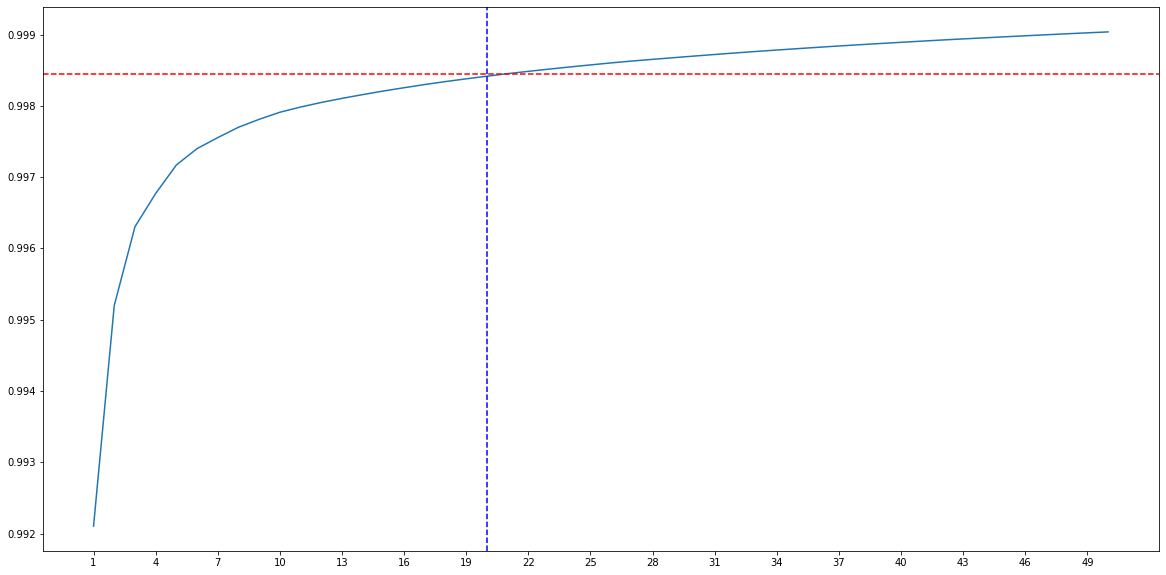

In [ ]:
# Visualzing the PCA for optimum no of PCs
fig = plt.figure(figsize=(20, 10)) 
x = range(1,x_train.shape[1]+1)
plt.xticks(np.arange(min(x), 51, 3.0))
sns.lineplot(y=np.cumsum(pca.explained_variance_ratio_[:50]),x = range(1,51))
plt.axhline(y=0.99845, color='r', linestyle='--')
plt.axvline(x=20, color='b', linestyle='--')

Out of 768 dimensions,only **20 dimensional data** could explain **99.84% variance** of data.


In [ ]:
# we take 11 principal components as it explains 99.8% of variance 
pca_new= PCA(n_components=20, random_state=42)
pca_train= pca_new.fit_transform(x_train)
pca_train.shape

(5728, 20)

In [ ]:
pca_columns=[]
for i in range(1,21):
    i=str(i)
    value='PCA'+i
    pca_columns.append(value)
df_train = pd.DataFrame(pca_train, columns=pca_columns,index=x_train.index)
df_train.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14,PCA15,PCA16,PCA17,PCA18,PCA19,PCA20
0,14.611555,0.374291,-0.027610,-0.190436,-0.468256,-0.453189,-0.031909,0.063972,-0.139020,0.030282,-0.028132,0.017393,0.095144,0.067748,-0.061398,0.073001,-0.094584,0.032299,0.060369,-0.150151
1,-12.746002,0.433599,-0.619970,0.166478,-0.557112,0.045851,-0.872665,0.050524,-0.161692,0.012113,-0.001802,0.069004,0.032701,0.066070,0.339659,-0.181525,0.129398,-0.000125,0.048145,0.091203
2,-12.974072,0.094273,-0.165440,0.042125,0.213158,-0.056517,-0.028904,0.008160,-0.044141,-0.003576,-0.017322,0.050320,0.051848,-0.046349,-0.038665,0.036184,-0.025566,-0.000108,0.036850,0.025482
3,15.220882,-2.154268,0.265459,0.431031,-0.085601,-0.107140,-0.034160,0.062973,-0.085473,0.126394,-0.068958,0.142078,0.020188,0.034583,0.033741,0.098227,-0.009423,0.017803,-0.043863,-0.020218
4,-12.983355,0.053846,-0.112174,0.140641,0.018356,0.016067,-0.067726,0.037043,-0.018321,0.086047,0.045006,-0.071414,0.043136,-0.117942,-0.036687,0.078981,0.044350,0.131215,0.095560,-0.013779


In [ ]:
#Applying selected components to the test data - 11 components
pca_test = pca_new.transform(x_test)
pca_test.shape

(811, 20)

In [ ]:
pca_columns=[]
for i in range(1,21):
    i=str(i)
    value='PCA'+i
    pca_columns.append(value)
df_test = pd.DataFrame(pca_test, columns=pca_columns,index=x_test.index)
df_test.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14,PCA15,PCA16,PCA17,PCA18,PCA19,PCA20
0,-12.994799,0.015741,-0.087510,0.040984,-0.158826,-0.019565,-0.254750,-0.017569,0.022806,-0.074567,-0.113135,0.044530,-0.043701,0.015066,0.215584,-0.138475,0.025714,-0.043675,-0.134477,-0.152025
1,14.416045,0.162261,0.701503,0.430803,0.359154,0.086245,-0.013670,0.320923,-0.077712,0.389170,-0.197261,-0.152301,-0.152626,-0.014025,0.103110,0.030712,0.081496,-0.049799,0.207770,-0.104858
2,-13.013250,0.220053,-0.389429,0.158356,0.293556,-0.072333,0.011838,-0.141063,-0.148427,0.033756,0.012854,-0.007482,0.037999,-0.009980,0.056956,-0.020139,-0.065626,0.018651,0.012415,-0.067363
3,-10.395929,0.693776,1.875468,0.740886,-1.145555,0.744189,0.060122,0.121721,-0.012940,0.204585,-0.055946,0.253422,-0.017891,0.568733,-0.284353,-0.310158,0.172016,0.056229,0.270779,0.105079
4,-12.751725,0.012231,0.314402,0.205846,-0.469746,0.292758,0.449456,-0.026206,-0.133566,-0.027286,0.048049,-0.073949,-0.058254,0.056493,0.055347,-0.001235,0.014248,-0.100053,-0.041855,-0.070072


In [ ]:
#Initializing MinMaxScalar

mms = MinMaxScaler()
#scaling the Training dataset
df_train[df_train.columns] = mms.fit_transform(df_train[df_train.columns])

#scaling the Test dataset
df_test[df_test.columns] = mms.transform(df_test[df_test.columns])

### **GRID SEARCH :** 

In [ ]:
def grid_search(algo,x,y,param_grid):
  """
  input   : algo : classification algorithm 
             x : x_train 
             y : y_train 
  prints  : best hyperparameters 
  """
  # Instantiate the grid search model
  grid_search = GridSearchCV(estimator = algo, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)
  # Fit the grid search to the data
  grid_search.fit(x, y)
  print('\n\nWe can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

### **SVM WITHOUT PCA :** 

In [ ]:
# Set the parameters by cross-validation
svc = SVC()
param_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}]
grid_search(svc,x_train,y_train,param_grid)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.




We can get accuracy of 1.0 using {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    2.2s finished


In [ ]:
svc_nonpca=SVC(C=1,gamma=0.001,kernel='rbf')

# fit
svc_nonpca.fit(x_train,y_train)

# predict
y_pred = pd.Series(svc_nonpca.predict(x_test))

accuracy_score(y_test,y_pred)

0.9149198520345253

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       435
           1       0.92      0.90      0.91       376

    accuracy                           0.91       811
   macro avg       0.92      0.91      0.91       811
weighted avg       0.91      0.91      0.91       811



### **SVM WITH PCA :** 

In [ ]:
# Set the parameters by cross-validation
svc = SVC()
param_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}]
grid_search(svc,df_train,y_train,param_grid)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    5.8s finished




We can get accuracy of 1.0 using {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}


In [ ]:
svc_pca=SVC(C=1,gamma=0.001,kernel='rbf')

# fit
svc_pca.fit(df_train,y_train)

# predict
y_pred = pd.Series(svc_pca.predict(df_test))

accuracy_score(y_test,y_pred)

0.9149198520345253

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       435
           1       0.92      0.90      0.91       376

    accuracy                           0.91       811
   macro avg       0.92      0.91      0.91       811
weighted avg       0.91      0.91      0.91       811



### **RANDOM FOREST WITHOUT PCA:**

In [ ]:
# Create a random forest model
rf = RandomForestClassifier()
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [2,4,6],
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(100, 400, 100),
    'n_estimators': [50,100,150], 
    'max_features': [3,5,7]
}
grid_search(rf,x_train,y_train,param_grid)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed:  1.9min finished




We can get accuracy of 1.0 using {'max_depth': 2, 'max_features': 3, 'min_samples_leaf': 50, 'min_samples_split': 100, 'n_estimators': 50}


In [ ]:
rfc_nonpca = RandomForestClassifier(bootstrap=True,
                             max_depth=2,
                             min_samples_leaf=50, 
                             min_samples_split=100,
                             max_features=3,
                             n_estimators=50)

# fit
rfc_nonpca.fit(x_train,y_train)

# predict
y_pred = pd.Series(rfc_nonpca.predict(x_test))
y_pred_prob = pd.Series(rfc_nonpca.predict_proba(x_test)[:,1])
accuracy_score(y_test,y_pred)

0.9149198520345253

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       435
           1       0.91      0.90      0.91       376

    accuracy                           0.91       811
   macro avg       0.91      0.91      0.91       811
weighted avg       0.91      0.91      0.91       811



### **RANDOM FOREST WITH PCA :**

In [ ]:
# Create a random forest model
rf = RandomForestClassifier()
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [2,4,6],
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(100, 400, 100),
    'n_estimators': [50,100,150], 
    'max_features': [3,5,7]
}
grid_search(rf,df_train,y_train,param_grid)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed:  2.8min finished




We can get accuracy of 1.0 using {'max_depth': 2, 'max_features': 3, 'min_samples_leaf': 50, 'min_samples_split': 100, 'n_estimators': 100}


In [ ]:
rfc_pca = RandomForestClassifier(bootstrap=True,
                             max_depth=2,
                             min_samples_leaf=50, 
                             min_samples_split=100,
                             max_features=3,
                             n_estimators=50)
# fit
rfc_pca.fit(df_train,y_train)

# predict
y_pred = pd.Series(rfc_pca.predict(df_test))
y_pred_prob = pd.Series(rfc_pca.predict_proba(df_test)[:,1])
accuracy_score(y_test,y_pred)

0.9149198520345253

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       435
           1       0.92      0.90      0.91       376

    accuracy                           0.91       811
   macro avg       0.92      0.91      0.91       811
weighted avg       0.91      0.91      0.91       811



### **XGBOOST WITHOUT PCA :**


In [ ]:
# Create a XGBoost model
xgb = XGBClassifier()

# Create the parameter grid based on the results of random search 
param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3]
}

grid_search(xgb,x_train,y_train,param_grid)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 11.6min finished




We can get accuracy of 1.0 using {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6}


In [ ]:
xgb_nonpca =  XGBClassifier(max_depth=3,colsample_bytree=0.6,
                             gamma=0.5, 
                             min_child_weight=1,
                             subsample=0.6)
# fit
xgb_nonpca.fit(x_train,y_train)

# predict
y_pred = pd.Series(xgb_nonpca.predict(x_test))
y_pred_prob = pd.Series(xgb_nonpca.predict_proba(x_test)[:,1])
accuracy_score(y_test,y_pred)

0.9198520345252774

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       435
           1       0.92      0.90      0.91       376

    accuracy                           0.92       811
   macro avg       0.92      0.92      0.92       811
weighted avg       0.92      0.92      0.92       811



### **XGBOOST WITH PCA:**


In [ ]:
# Create a XGBoost model
xgb = XGBClassifier()

# Create the parameter grid based on the results of random search 
param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3]
}

grid_search(xgb,df_train,y_train,param_grid)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   29.6s finished




We can get accuracy of 1.0 using {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6}


In [ ]:
xgb_pca =  XGBClassifier(max_depth=3,colsample_bytree=0.6,
                             gamma=0.5, 
                             min_child_weight=1,
                             subsample=0.6)
# fit
xgb_pca.fit(df_train,y_train)

# predict
y_pred = pd.Series(xgb_pca.predict(df_test))
y_pred_prob = pd.Series(xgb_pca.predict_proba(df_test)[:,1])
accuracy_score(y_test,y_pred)

0.9149198520345253

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       435
           1       0.92      0.90      0.91       376

    accuracy                           0.91       811
   macro avg       0.92      0.91      0.91       811
weighted avg       0.91      0.91      0.91       811



### **GBDT WITHOUT PCA :**


In [ ]:
# grid search to find the optimal hyperparameters

# Create a GBDT model
gbdt=GradientBoostingClassifier()

# Create the parameter grid based on the results of random search 
param_grid = {
     'max_depth': [2,4,6],
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(100, 400, 100),
    'n_estimators': [50,100,150], 
    'max_features': [3,5,7]
}
grid_search(gbdt,x_train,y_train,param_grid)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed:  1.4min finished




We can get accuracy of 1.0 using {'max_depth': 2, 'max_features': 3, 'min_samples_leaf': 50, 'min_samples_split': 100, 'n_estimators': 50}


In [ ]:
gbdt_nonpca = GradientBoostingClassifier(max_depth=2,
                             min_samples_leaf=50, 
                             min_samples_split=100,
                             max_features=3,
                             n_estimators=50)
# fit
gbdt_nonpca.fit(x_train,y_train)

# predict
y_pred = pd.Series(gbdt_nonpca.predict(x_test))
y_pred_prob = pd.Series(gbdt_nonpca.predict_proba(x_test)[:,1])
accuracy_score(y_test,y_pred)

0.9136868064118372

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       435
           1       0.91      0.90      0.91       376

    accuracy                           0.91       811
   macro avg       0.91      0.91      0.91       811
weighted avg       0.91      0.91      0.91       811



### **GBDT WITH PCA :**

In [ ]:
# grid search to find the optimal hyperparameters

# Create a GBDT model
gbdt=GradientBoostingClassifier()

# Create the parameter grid based on the results of random search 
param_grid = {
     'max_depth': [2,4,6],
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(100, 400, 100),
    'n_estimators': [50,100,150], 
    'max_features': [3,5,7]
}
grid_search(gbdt,df_train,y_train,param_grid)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed:  4.0min finished




We can get accuracy of 1.0 using {'max_depth': 2, 'max_features': 3, 'min_samples_leaf': 50, 'min_samples_split': 100, 'n_estimators': 50}


In [ ]:
gbdt_pca = GradientBoostingClassifier(max_depth=2,
                             min_samples_leaf=50, 
                             min_samples_split=100,
                             max_features=3,
                             n_estimators=50)
# fit
gbdt_pca.fit(df_train,y_train)

# predict
y_pred = pd.Series(gbdt_pca.predict(df_test))
y_pred_prob = pd.Series(gbdt_pca.predict_proba(df_test)[:,1])
accuracy_score(y_test,y_pred)

0.9149198520345253

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       435
           1       0.92      0.90      0.91       376

    accuracy                           0.91       811
   macro avg       0.92      0.91      0.91       811
weighted avg       0.91      0.91      0.91       811

